# 🎨 Classificador de Estilos Artísticos com Deep Learning

Este notebook implementa um modelo de Deep Learning para classificar imagens de pinturas em diferentes estilos artísticos.

Usamos **Transfer Learning com a MobileNetV2**, técnicas de aumento de dados e uma análise profunda de erros para entender o comportamento do modelo.

---

**Objetivos:**
- Classificar estilos artísticos com base em imagens.
- Avaliar o desempenho com métricas visuais.
- Explorar erros para identificar padrões de generalização.

## 🔧 Importação das Bibliotecas

Importamos TensorFlow, Keras, bibliotecas de visualização e utilitários como `os`, `json`, `re`, entre outros.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import json
import os
import re
import unicodedata

## 📂 Limpeza dos Arquivos de Imagem

Antes de treinar, é importante padronizar os nomes dos arquivos. Aqui, usamos uma função `sanitize_filename` para:

- Remover acentos e caracteres especiais
- Evitar nomes duplicados
- Garantir compatibilidade entre sistemas operacionais

Isso ajuda na hora de carregar os dados com o `image_dataset_from_directory`.


In [2]:
def sanitize_filename(filename):
    """
    Limpa um nome de arquivo, removendo caracteres especiais e acentos.
    Ex: "abc.-nome(1) ç.jpg" -> "abc_-nome_1__c.jpg"
    """
    # 1. Normaliza para decompor caracteres acentuados (ex: 'ç' -> 'c' + '̧')
    # e remove os acentos (a parte '̧')
    sanitized = unicodedata.normalize('NFKD', filename).encode('ascii', 'ignore').decode('ascii')
    
    # 2. Substitui qualquer caractere que NÃO seja letra, número, ponto, hífen ou underscore por um underscore
    sanitized = re.sub(r'[^\w.\-]', '_', sanitized)
    
    # 3. Evita múltiplos underscores seguidos
    sanitized = re.sub(r'__+', '_', sanitized)
    
    return sanitized

# --- SCRIPT PRINCIPAL DE RENOMEAÇÃO ---

# Substitua pelo caminho da sua pasta principal de imagens
DATA_DIR = "C:/Users/Jorge Maques/Downloads/WikiArt/" 

renamed_count = 0
print(f"Iniciando a limpeza de nomes de arquivos em: {DATA_DIR}\n")

# os.walk vai percorrer todas as pastas e subpastas
for dirpath, dirnames, filenames in os.walk(DATA_DIR):
    print(f"Processando a pasta: {os.path.basename(dirpath)}")
    for filename in filenames:
        original_filepath = os.path.join(dirpath, filename)
        
        # Gera o novo nome limpo
        sanitized_name = sanitize_filename(filename)
        
        # Se o nome limpo for diferente do original, renomeia
        if sanitized_name != filename:
            new_filepath = os.path.join(dirpath, sanitized_name)
            
            # Garante que o novo nome não colida com um arquivo já existente
            counter = 1
            while os.path.exists(new_filepath):
                name, ext = os.path.splitext(sanitized_name)
                new_filepath = os.path.join(dirpath, f"{name}_{counter}{ext}")
                counter += 1

            # Renomeia o arquivo
            os.rename(original_filepath, new_filepath)
            # print(f"  Renomeado: '{filename}' -> '{os.path.basename(new_filepath)}'")
            renamed_count += 1

print(f"\nProcesso concluído! {renamed_count} arquivos foram renomeados.")

Iniciando a limpeza de nomes de arquivos em: C:/Users/Jorge Maques/Downloads/WikiArt/

Processando a pasta: 
Processando a pasta: Abstract_Expressionism
Processando a pasta: Analytical_Cubism
Processando a pasta: Art_Nouveau_Modern
Processando a pasta: Baroque
Processando a pasta: Cubism
Processando a pasta: Expressionism
Processando a pasta: Impressionism

Processo concluído! 0 arquivos foram renomeados.


## ⚙️ Parâmetros Iniciais e Visualização das Classes

Definimos altura, largura e tamanho do batch.  
Em seguida, listamos as **classes artísticas** detectadas automaticamente com base nas pastas do dataset.


In [3]:
# Parâmetros para as imagens e o treinamento
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32 # Quantas imagens processar de cada vez

# --- Verificar se o caminho está correto e listar as classes ---
try:
    class_names = os.listdir(DATA_DIR)
    print("Estilos encontrados (classes):")
    for i in range(len(class_names)):
       print(class_names[i])
    NUM_CLASSES = len(class_names)
except FileNotFoundError:
    print(f"ERRO: O diretório '{DATA_DIR}' não foi encontrado. Por favor, verifique o caminho.")

Estilos encontrados (classes):
Abstract_Expressionism
Analytical_Cubism
Art_Nouveau_Modern
Baroque
Cubism
Expressionism
Impressionism


## 📊 Criação dos Datasets (Treino e Validação)

Usamos `image_dataset_from_directory` com `validation_split=0.2` para separar os dados.

O `seed` garante reprodutibilidade, e a imagem é redimensionada para 224x224 pixels (padrão da MobileNetV2).


In [4]:
# Criando o dataset de treinamento (80% dos dados)
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123, # Seed para garantir que a divisão seja sempre a mesma
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

# Criando o dataset de validação (20% dos dados)
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

# Verificar os nomes das classes que o Keras inferiu (deve bater com a lista anterior)
print("\nNomes das classes inferidos pelo Keras:", train_ds.class_names)

# Salvar os nomes das classes para usar na aplicação Flask depois
with open('class_names.json', 'w') as f:
    json.dump(train_ds.class_names, f)

Found 3722 files belonging to 7 classes.
Using 2978 files for training.
Found 3722 files belonging to 7 classes.
Using 744 files for validation.

Nomes das classes inferidos pelo Keras: ['Abstract_Expressionism', 'Analytical_Cubism', 'Art_Nouveau_Modern', 'Baroque', 'Cubism', 'Expressionism', 'Impressionism']


## 🖼️ Visualização das Imagens de Treino

Selecionamos 9 imagens aleatórias do dataset de treino para confirmar que:

- O carregamento foi bem-sucedido
- As imagens e os rótulos estão corretos


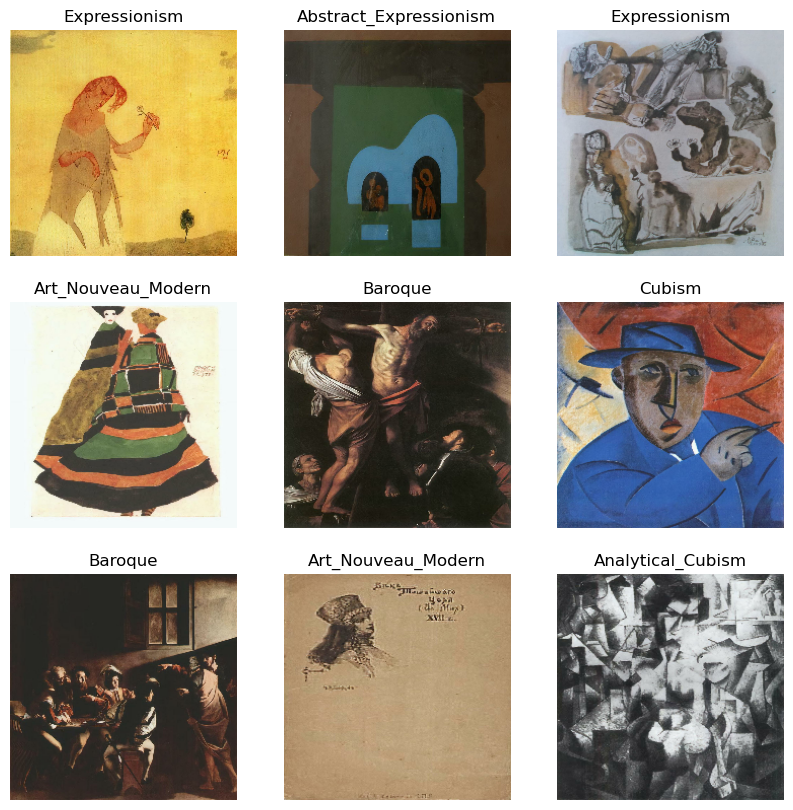

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # Pega um batch de imagens
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 🔁 Data Augmentation e Pré-processamento

Para reduzir overfitting, aplicamos transformações como:

- Flip horizontal
- Pequenas rotações
- Zoom

O `preprocess_input` da MobileNetV2 também é aplicado para normalizar os valores dos pixels.


In [6]:
# Camada para fazer o Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

# A MobileNetV2 espera que os pixels estejam no intervalo [-1, 1].
# A função preprocess_input faz exatamente isso.
# Vamos criar uma função para aplicar isso aos nossos datasets.
def preprocess_dataset(image, label):
    return preprocess_input(image), label

# Otimização dos datasets para performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 🧠 Construção do Modelo com Transfer Learning

Usamos a MobileNetV2 como **extrator de características congelado** (`trainable=False`), adicionando nossa própria "cabeça" de classificação no topo:

- GlobalAveragePooling2D
- Dropout (para regularização)
- Dense com softmax (para classificação entre estilos)


In [7]:
# --- Carregar o Modelo Base ---
# Usaremos a MobileNetV2, que é leve e eficiente.
# include_top=False remove a camada de classificação final original do ImageNet.
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet' # Carrega os pesos pré-treinados no ImageNet
)

# --- Congelar o Modelo Base ---
# Não queremos retreinar os pesos que o Google já treinou por semanas.
# Queremos apenas usá-los como um extrator de features fixo.
base_model.trainable = False

# --- Construir a "Cabeça" do Nosso Modelo ---
# Vamos usar a API Funcional do Keras, que é mais flexível.

# 1. Definir a entrada do modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 2. Aplicar Data Augmentation (será ativado apenas durante o treino)
x = data_augmentation(inputs)

# 3. Aplicar o pré-processamento específico da MobileNetV2
x = preprocess_input(x)

# 4. Passar os dados pelo modelo base
x = base_model(x, training=False) # training=False garante que o base_model rode em modo de inferência

# 5. Adicionar nossas próprias camadas no topo
x = GlobalAveragePooling2D()(x) # Achata as features de forma inteligente
x = Dropout(0.2)(x) # Camada de Dropout para regularização e evitar overfitting
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Nossa camada de saída final!

# 6. Juntar tudo em um modelo final
model = Model(inputs, predictions)

# --- Visualizar a Arquitetura ---
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 🚀 Compilação e Treinamento do Modelo

Compilamos o modelo com:

- Otimizador: Adam
- Perda: Sparse Categorical Crossentropy
- Métrica: Acurácia

Usamos os seguintes callbacks:

- `EarlyStopping`: evita overfitting
- `ModelCheckpoint`: salva o melhor modelo

O treino é interrompido automaticamente se a validação parar de melhorar.


In [8]:
# --- Compilar o Modelo ---
# Usamos 'adam' como otimizador, que é um bom padrão.
# A perda 'sparse_categorical_crossentropy' é ideal quando os labels são números inteiros (0, 1, 2...).
# A métrica principal que queremos observar é a 'accuracy'.
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# --- Definir Callbacks (Ações Automáticas Durante o Treino) ---
# EarlyStopping: para o treino se a performance não melhorar, economizando tempo.
# ModelCheckpoint: salva o melhor modelo encontrado durante o treino.
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('art_style_classifier_best.keras', save_best_only=True)
]


# --- Treinar o Modelo! ---
INITIAL_EPOCHS = 30 # Número máximo de épocas. O EarlyStopping pode parar antes.

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks
)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.3470 - loss: 1.7724 - val_accuracy: 0.5874 - val_loss: 1.1178
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.5951 - loss: 1.1088 - val_accuracy: 0.6290 - val_loss: 1.0166
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.6424 - loss: 0.9703 - val_accuracy: 0.6478 - val_loss: 0.9823
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.6628 - loss: 0.9244 - val_accuracy: 0.6384 - val_loss: 0.9776
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.6969 - loss: 0.8700 - val_accuracy: 0.6398 - val_loss: 0.9742
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 364s 4s/step - accuracy: 0.7173 - loss: 0.8169 - val_accuracy: 0.6425 - val_loss: 0.9690
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.7129 - loss: 0.7955 - val_accuracy: 0.6384 - val_loss: 0.9695
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 338s 4s/step - accuracy: 0.7112 - loss: 0.7855 - val_accuracy: 0.6532 - v

## 📈 Avaliação: Gráficos de Acurácia e Perda

Visualizamos:

- Acurácia de treino vs validação
- Perda de treino vs validação

Esses gráficos ajudam a detectar overfitting, subajuste ou variações instáveis.


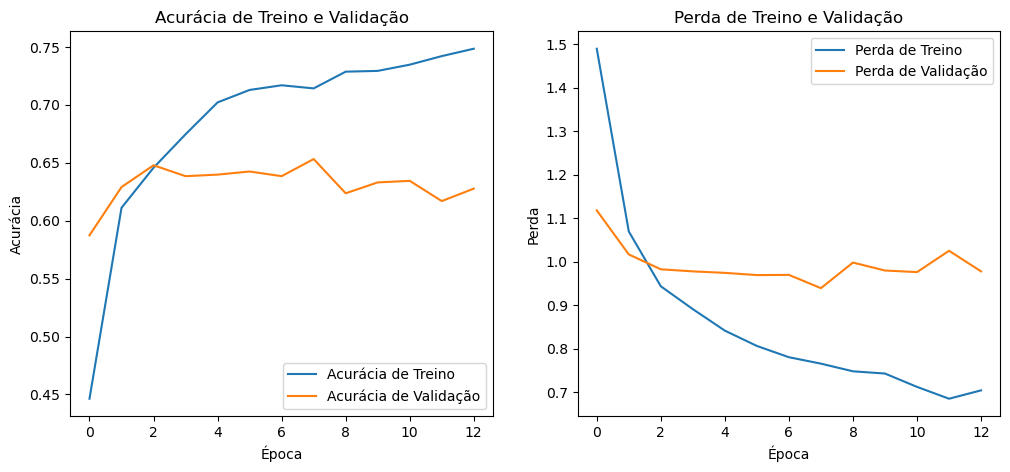

24/24 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.6423 - loss: 0.9508

Acurácia final no dataset de validação: 65.32%


In [9]:
# --- Plotar os Gráficos de Treinamento ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Acurácia de Treino')
plt.plot(val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Perda de Treino')
plt.plot(val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.show()

# --- Avaliação Final no Dataset de Validação ---
# O callback 'restore_best_weights=True' já garantiu que nosso modelo está com os melhores pesos.
loss, accuracy = model.evaluate(val_ds)
print(f"\nAcurácia final no dataset de validação: {accuracy:.2%}")

## 🔍 Matriz de Confusão

A matriz mostra onde o modelo mais errou.  
Isso ajuda a identificar confusões entre estilos similares visualmente, como:

- **Barroco vs Impressionismo**
- **Expressionismo vs Expressionismo Abstrato**


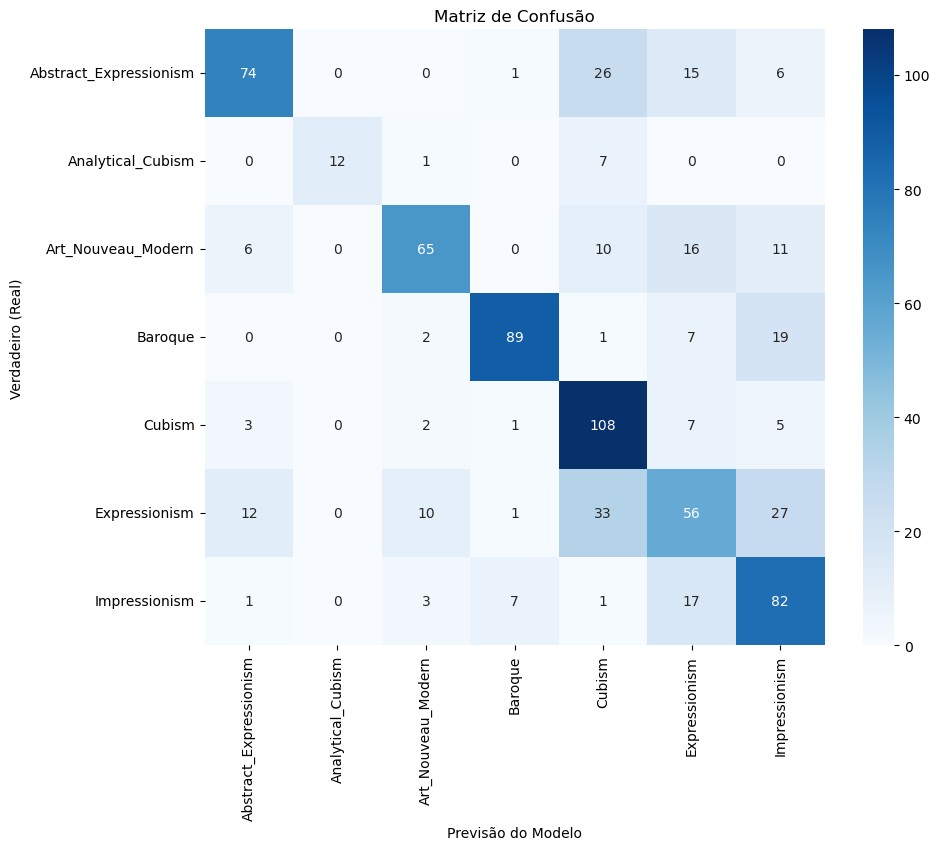

In [10]:
# 1. Pegar todas as previsões e labels do dataset de validação
y_pred = []
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Criar a Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

# 3. Plotar a Matriz de Confusão de forma visual
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão do Modelo')
plt.ylabel('Verdadeiro (Real)')
plt.title('Matriz de Confusão')
plt.show()

## Análise da Matriz de Confusão
A matriz revela que a maior confusão ocorre entre:
Barroco e Impressionismo (19 erros)
Expressionismo e Expressionismo Abstrato (12 erros)
A confusão entre Expressionismo e sua vertente Abstrata é esperada, dado o parentesco estilístico. A confusão entre Barroco e Impressionismo é mais surpreendente e merece uma investigação mais profunda.

### Estudo de Caso: O Erro em "View of Scheveningen Sands"
Ao testar o modelo com imagens individuais do dataset de treino, identificamos que a obra barroca "View of Scheveningen Sands" foi classificada incorretamente como Impressionista.

#### Hipótese
A CNN não "vê" o contexto histórico, mas sim padrões de pixels. Nesta obra:
**Céu Dominante:** O céu atmosférico ocupa ~70% da composição.
**Regra Generalizada:** O modelo aprendeu, através de milhares de exemplos, a associar "céus vastos e luminosos" com o estilo Impressionista.
**Conclusão:** A "regra do céu" aprendida pelo modelo foi mais forte do que as outras características barrocas da imagem (cores, figuras), levando à classificação incorreta. Isso indica que o modelo está generalizando com sucesso, em vez de sofrer overfitting, pois aplicou uma regra aprendida em vez de memorizar o rótulo da imagem.

## ✅ Conclusão

Este projeto demonstra o uso prático de Deep Learning para tarefas de visão computacional com Transfer Learning.  
Mesmo com um dataset relativamente pequeno, o modelo foi capaz de aprender padrões relevantes e **generalizar visualmente**.

A análise dos erros é especialmente importante para compreender os limites e possibilidades de modelos baseados em CNNs.

---

➡️ A próxima etapa seria explorar:

- Fine-tuning do modelo base
- Aumento do dataset com mais estilos
- Explicabilidade com Grad-CAM
